### import dependecies

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import shap
import numpy as np
from tqdm import tqdm
import sys
import json

c:\Users\frmar\OneDrive\Desktop\GitHub\CNN-explainability-Earthquakes\CNN_EQML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## CNN on log spectrograms

### Data Loading

In [2]:
# Path to the dataset
base_data_path = r'C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms'
train_data_path = base_data_path + r"\train"
valid_data_path = base_data_path + r"\valid"
test_data_path = base_data_path + r"\test"

In [5]:
def calculate_and_save_stats(train_data_path, stats_file):
    print("Calculating dataset statistics for normalization...")
    all_pixels = []
    for root, dirs, files in os.walk(train_data_path):
        for file in files:
            if file.endswith(".png"):
                img_path = os.path.join(root, file)
                try:
                    image = Image.open(img_path).convert("RGB")
                    all_pixels.append(np.array(image) / 255.0)
                except Exception as e:
                    print(f"Skipping invalid image: {img_path}")
                    continue
    if not all_pixels:
        raise ValueError("No valid images found in the dataset.")
    all_pixels = np.concatenate([img.reshape(-1, 3) for img in all_pixels], axis=0)
    mean = all_pixels.mean(axis=0)
    std = all_pixels.std(axis=0)

    # Save statistics to a file
    with open(stats_file, "w") as f:
        json.dump({"mean": mean.tolist(), "std": std.tolist()}, f)

    print(f"Mean: {mean}, Std: {std} (calculated and saved)")
    return mean, std

def load_stats(stats_file):
    with open(stats_file, "r") as f:
        stats = json.load(f)
    mean = np.array(stats["mean"])
    std = np.array(stats["std"])
    print(f"Mean: {mean}, Std: {std} (loaded from file)")
    return mean, std

In [6]:
stats_file = base_data_path + r"\metrics.json"

In [7]:
# Load\Calculate mean and std dynamically 

if os.path.exists(stats_file):
    # Load saved statistics
    mean, std = load_stats(stats_file)
else:
    # Calculate and save statistics
    # Approximately 3 minutes for the entire training set (~50'000 images)
    mean, std = calculate_and_save_stats(train_data_path, stats_file)


Mean: [0.01005489 0.01015358 0.01138446], Std: [0.0485352  0.04866005 0.04982412] (loaded from file)


In [11]:
# Define custom dataset
'''
class EarthquakeDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.file_list = [f for f in os.listdir(data_path) if f.endswith(".png")]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.data_path, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            raise

        # Extract label from filename
        if "_post.png" in img_name:
            label = 1  # Aftershock
        elif "_pre.png" in img_name:
            label = 0  # Mainshock
        else:
            raise ValueError("Filename does not match expected pattern")

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
'''

In [8]:
from PIL import UnidentifiedImageError

from PIL import Image, UnidentifiedImageError
import os
import torch
from torchvision import transforms

class EarthquakeDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.valid_files = []

        # Verify files during initialization
        for root, dirs, files in os.walk(data_path):
            for file in files:
                if file.endswith(".png"):
                    file_path = os.path.join(root, file)
                    try:
                        # Attempt to open the file to verify it's valid
                        with Image.open(file_path) as img:
                            img.verify()  # Check if the file is a valid image
                        self.valid_files.append(file_path)  # Add valid files
                    except (UnidentifiedImageError, OSError):
                        print(f"Skipping invalid file: {file_path}")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        img_path = self.valid_files[idx]  # Use self.valid_files
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            raise

        # Extract label from filename
        if "_post.png" in img_path:
            label = 1  # Aftershock
        elif "_pre.png" in img_path:
            label = 0  # Mainshock
        else:
            raise ValueError("Filename does not match expected pattern")

        if self.transform:
            image = self.transform(image)

        return image, label


# Transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [9]:
# Create datasets and dataloaders
dataset = EarthquakeDataset(train_data_path, transform=transform)
valid_dataset = EarthquakeDataset(valid_data_path, transform=transform)
test_dataset = EarthquakeDataset(test_data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0) 
# Dataloaders batches are shaped (32, 3, 33, 153)

Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms\train\FDMO.IV.100017451_EV_pre.png
Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms\train\MMO1.IV.100364611_EV_post.png
Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms\train\T1212.IV.100399621_EV_post.png
Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms\train\T1212.IV.100401452_EV_post.png
Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms\train\T1214.IV.100019705_EV_pre.png
Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preprocessed\data_preprocessed\spectrograms\train\T1216.IV.100099881_EV_post.png
Skipping invalid file: C:\Users\frmar\OneDrive\Desktop\EQML Project\data_preproc

### CNN and training utils function definition

In [10]:
class CNN2D(nn.Module):
    def __init__(self, num_classes):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BatchNorm3 = nn.BatchNorm2d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        # Update fc1 to reflect the correct input size after convolution and pooling
        self.fc1 = nn.Linear(128 * 4 * 19, 128)  # Adjusted based on H=33, W=153
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.maxpool(self.BatchNorm1(self.conv1(x))))
        x = self.relu(self.maxpool(self.BatchNorm2(self.conv2(x))))
        x = self.relu(self.BatchNorm3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNN2D(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [12]:
# Function to calculate accuracy
def calculate_accuracy(model, dataloader, dataset_name):
    print(f"Calculating accuracy on {dataset_name} set...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training loop
def train_model(model, dataloader, valid_dataloader, criterion, optimizer, num_epochs=10):
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0

        total_batches = len(dataloader)  # Total number of batches in the training set

        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate the percentage of the training set trained on
            percent_trained = (batch_idx + 1) / total_batches * 100

            # Print progress on the same line
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{total_batches} - {percent_trained:.2f}% of training set trained", end='\r')
            sys.stdout.flush()  # Force the output to be updated immediately

        print()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")
        epoch_loss = running_loss / len(dataloader.dataset)
        train_accuracy = calculate_accuracy(model, dataloader, "Training")
        valid_accuracy = calculate_accuracy(model, valid_dataloader, "Validation")

        print(f"Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}")


### Training\Loading model

In [45]:
# Train the model
train_model(model, dataloader, valid_dataloader, criterion, optimizer, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 1/10, Loss: 32737.7914
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 10%|█         | 1/10 [03:17<29:38, 197.57s/it]

Train Accuracy: 0.7505, Valid Accuracy: 0.7448
Epoch 2/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 2/10, Loss: 23781.8187
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 20%|██        | 2/10 [06:33<26:13, 196.74s/it]

Train Accuracy: 0.8224, Valid Accuracy: 0.8075
Epoch 3/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 3/10, Loss: 18202.6219
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 30%|███       | 3/10 [09:47<22:46, 195.20s/it]

Train Accuracy: 0.8718, Valid Accuracy: 0.8457
Epoch 4/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 4/10, Loss: 15036.6674
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 40%|████      | 4/10 [13:01<19:30, 195.03s/it]

Train Accuracy: 0.9132, Valid Accuracy: 0.8725
Epoch 5/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 5/10, Loss: 12917.3433
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 50%|█████     | 5/10 [16:14<16:10, 194.06s/it]

Train Accuracy: 0.9052, Valid Accuracy: 0.8622
Epoch 6/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 6/10, Loss: 11064.6095
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 60%|██████    | 6/10 [19:25<12:52, 193.17s/it]

Train Accuracy: 0.9288, Valid Accuracy: 0.8745
Epoch 7/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 7/10, Loss: 9820.0677
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 70%|███████   | 7/10 [22:38<09:39, 193.22s/it]

Train Accuracy: 0.9415, Valid Accuracy: 0.8746
Epoch 8/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 8/10, Loss: 8398.1046
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 80%|████████  | 8/10 [25:54<06:28, 194.06s/it]

Train Accuracy: 0.9504, Valid Accuracy: 0.8773
Epoch 9/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 9/10, Loss: 7359.1496
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


 90%|█████████ | 9/10 [29:11<03:15, 195.01s/it]

Train Accuracy: 0.9524, Valid Accuracy: 0.8743
Epoch 10/10, Batch 1738/1738 - 100.00% of training set trained
Epoch 10/10, Loss: 6205.3311
Calculating accuracy on Training set...
Calculating accuracy on Validation set...


100%|██████████| 10/10 [32:25<00:00, 194.52s/it]

Train Accuracy: 0.9611, Valid Accuracy: 0.8782


In [47]:
# Save model
torch.save(model.state_dict(), r"trained_models\cnn_non_log.pth")

In [13]:
# Load model
model = CNN2D(num_classes=2).to(device)
model.load_state_dict(torch.load(r"trained_models\cnn_non_log.pth", map_location=device))
model.eval()
print("Model successfully loaded and ready for inference.")

Model successfully loaded and ready for inference.


C:\Users\frmar\AppData\Local\Temp\ipykernel_4800\3847499948.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"trained_models\cnn_non_log

### Visualize Metrics

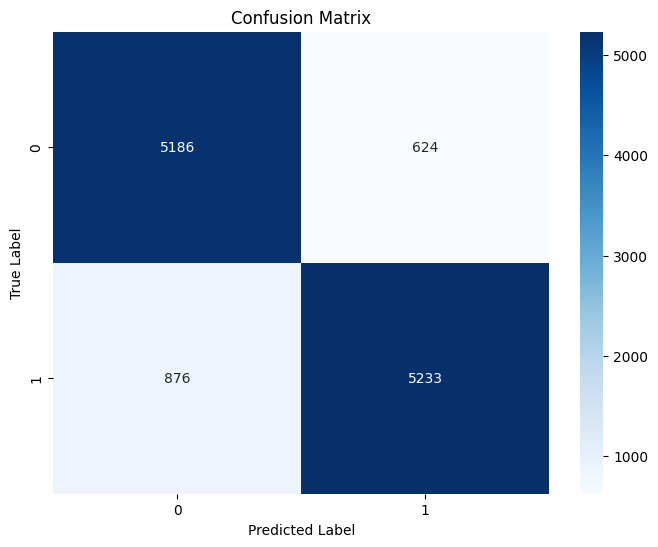


Classification Report:
              precision    recall  f1-score   support

   Mainshock       0.86      0.89      0.87      5810
  Aftershock       0.89      0.86      0.87      6109

    accuracy                           0.87     11919
   macro avg       0.87      0.87      0.87     11919
weighted avg       0.87      0.87      0.87     11919


Test Accuracy: 0.8742
Precision: 0.8935
Recall: 0.8566
F1 Score: 0.8746


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

import matplotlib.pyplot as plt

# Create test dataset and dataloader
test_data_path = base_data_path + r"\test"
test_dataset = EarthquakeDataset(test_data_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get predictions
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Mainshock', 'Aftershock']))

# Calculate accuracy
accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Calculate performance metrics
precision = cm[1,1] / (cm[0,1] + cm[1,1])
recall = cm[1,1] / (cm[1,0] + cm[1,1])
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

### Explainability

In [26]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt

# since shuffle=True, this is a random sample of test data
batch = next(iter(test_dataloader))
images, _ = batch

background = images[:16]
test_images = images[16:]




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
background = background.to(device)
test_images = test_images.to(device)

print("Background shape:", background.shape)
print("Test images shape:", test_images.shape)
print("Model output shape:", model(background).shape)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)


shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)


Background shape: torch.Size([16, 3, 33, 153])
Test images shape: torch.Size([16, 3, 33, 153])
Model output shape: torch.Size([16, 2])


RuntimeError: The size of tensor a (19) must match the size of tensor b (128) at non-singleton dimension 3